In [1]:
import config
import pandas as pd
import glob

##### Notes:

- Normalize and add extra features data and compare to previous kata results

##### Results:

- No significant improvements

### Load Data

In [2]:
data_files = glob.glob(config.data_dir+'*.csv')
dfs = []
for i,f in enumerate(data_files):
    df_i = pd.read_csv(f,sep=',',names=config.cols)
    df_i['participant_id'] = i
    dfs.append(df_i)

In [4]:
dfs[0].head(0)

,sequential_number,x_acceleration,y_acceleration,z_acceleration,label,participant_id


### Preprocess Data

##### Mean filtering of sensor data

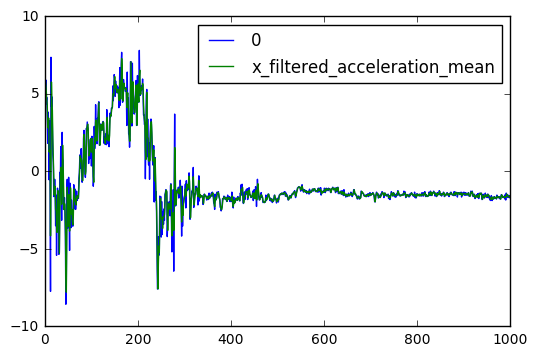

In [113]:
%matplotlib inline

df_test = dfs[0][['x_acceleration']].copy()
standard_scaler = StandardScaler(with_mean=True,with_std=True) 
df_test = standard_scaler.fit_transform(df_test)
df_test  = pd.DataFrame(df_test)
df_test['x_filtered_acceleration_mean'] = df_test.rolling(2,min_periods=1).mean()
df_test.plot(xlim=(0,1000))


##### Feature Engineering

In [92]:
def create_features(df_i, window_size=int(config.sampling_freq) ):
    df_i['x_filtered'] = df_i[['x_acceleration']].rolling(2,min_periods=1).mean()
    df_i['y_filtered'] = df_i[['y_acceleration']].rolling(2,min_periods=1).mean()
    df_i['z_filtered'] = df_i[['z_acceleration']].rolling(2,min_periods=1).mean()
    
    df_i['x_win_mean'] = df_i[['x_acceleration']].rolling(window_size,min_periods=1).mean()
    df_i['y_win_mean'] = df_i[['y_acceleration']].rolling(window_size,min_periods=1).mean()
    df_i['z_win_mean'] = df_i[['z_acceleration']].rolling(window_size,min_periods=1).mean()

    df_i['x_win_median'] = df_i[['x_acceleration']].rolling(window_size,min_periods=1).median()
    df_i['y_win_median'] = df_i[['y_acceleration']].rolling(window_size,min_periods=1).median()
    df_i['z_win_median'] = df_i[['z_acceleration']].rolling(window_size,min_periods=1).median()

    df_i['x_win_max'] = df_i[['x_acceleration']].rolling(window_size,min_periods=1).max()
    df_i['y_win_max'] = df_i[['y_acceleration']].rolling(window_size,min_periods=1).max()
    df_i['z_win_max'] = df_i[['z_acceleration']].rolling(window_size,min_periods=1).max()

    df_i['x_win_min'] = df_i[['x_acceleration']].rolling(window_size,min_periods=1).min()
    df_i['y_win_min'] = df_i[['y_acceleration']].rolling(window_size,min_periods=1).min()
    df_i['z_win_min'] = df_i[['z_acceleration']].rolling(window_size,min_periods=1).min()

    df_i = df_i.dropna()
    return df_i

In [93]:
# compute features for each participant
dfs_processed = [create_features(df_i,window_size=int(config.sampling_freq*3.0)) for df_i in dfs]

#  preprocess data to remove instances with zero as a label
dfs_processed = [ df_i[df_i['label']>0] for df_i in dfs_processed]

In [94]:
# create a list of (X,y) tuples
X_cols = ['x_filtered','y_filtered','z_filtered',
        'x_win_mean','y_win_mean','z_win_mean',
        'x_win_median','y_win_median','z_win_median',
        'x_win_max','y_win_max','z_win_max',
        'x_win_min','y_win_min','z_win_min']

y_cols = 'label'

# Array of (X,y) for each participant
data_participant = [(df_i[X_cols],df_i[y_cols]) for df_i in dfs_processed]

# (X,y) of combined dataset
df_concat = pd.concat(dfs_processed)
data_combined = (df_concat[X_cols],df_concat[y_cols])

##### Z-score normalization

$z=\frac{x-\mu}{\sigma}$

$ x $ : data

$ \mu $: mean

$ \sigma $ : standard deviation

In [95]:
# Normalize Data using sklearn
from sklearn.preprocessing import StandardScaler


def normalize(X,y):
    
    standard_scaler = StandardScaler(with_mean=True,with_std=True) 
    X_norm = standard_scaler.fit_transform(X)
    # previous step creates a numpy.array, we'll convert to DataFrame
    X_norm_df  = pd.DataFrame(X_norm,columns=X_cols)
        
    return (X_norm_df,y)

In [96]:
data_norm_participant = [normalize(X_i,y_i) for X_i,y_i in data_participant]
data_norm_combined    = normalize(data_combined[0],data_combined[1])

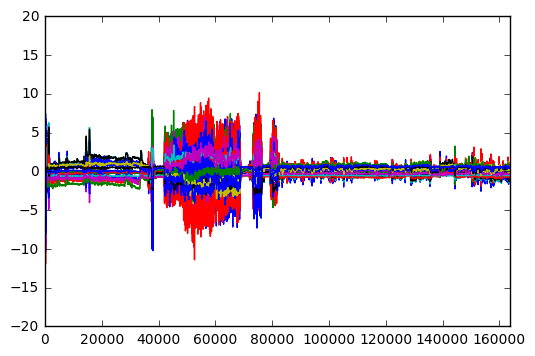

In [97]:
%matplotlib inline
for i,_ in enumerate(data_norm_participant):
    data_norm_participant[i][0].plot(legend=False,ylim=(-20,20))
    break

### Training and Cross-Validation

In [98]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [99]:
clf_rf = RandomForestClassifier(n_jobs=-1,n_estimators=100,random_state=2)

In [100]:
def train_and_score(clf,X,y):
    clf_score = cross_val_score(clf,X,y,cv=5,n_jobs=-1)
    return clf_score

##### Create a model and calculate score for each participant separately

In [101]:
%%time
for i,d in enumerate(data_norm_participant):
    X,y = d[0],d[1]
    clf_score = train_and_score(clf_rf,X,y)
    print("Participant {}\t".format(i),"Accuracy: %0.2f (+/- %0.2f)" % (clf_score.mean(), clf_score.std() * 2))

Participant 0	 Accuracy: 0.86 (+/- 0.13)
Participant 1	 Accuracy: 0.73 (+/- 0.35)
Participant 2	 Accuracy: 0.73 (+/- 0.36)
Participant 3	 Accuracy: 0.73 (+/- 0.17)
Participant 4	 Accuracy: 0.72 (+/- 0.33)
Participant 5	 Accuracy: 0.76 (+/- 0.22)
Participant 6	 Accuracy: 0.87 (+/- 0.11)
Participant 7	 Accuracy: 0.75 (+/- 0.19)
Participant 8	 Accuracy: 0.67 (+/- 0.24)
Participant 9	 Accuracy: 0.84 (+/- 0.24)
Participant 10	 Accuracy: 0.80 (+/- 0.32)
Participant 11	 Accuracy: 0.90 (+/- 0.13)
Participant 12	 Accuracy: 0.87 (+/- 0.12)
Participant 13	 Accuracy: 0.73 (+/- 0.29)
Participant 14	 Accuracy: 0.71 (+/- 0.34)
CPU times: user 5.17 s, sys: 2.47 s, total: 7.64 s
Wall time: 4min 45s


##### Run with combined dataset

In [53]:
%%time
X,y = data_norm_combined[0],data_norm_combined[1]
clf_score = train_and_score(clf_rf,X,y)
print("Participant {}\t".format(i),"Accuracy: %0.2f (+/- %0.2f)" % (clf_score.mean(), clf_score.std() * 2))

Participant 14	 Accuracy: 0.44 (+/- 0.06)
CPU times: user 3.74 s, sys: 320 ms, total: 4.06 s
Wall time: 8min 25s


In [55]:
# Feature Ranking
import numpy as np

X,y = data_norm_combined[0],data_norm_combined[1]
clf_rf.fit(X,y)
print("Feature ranking:")
importances = clf_rf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
    print("{}.\tfeature {}\t({})".format(f + 1, X.columns[int(indices[f])], importances[indices[f]]))

Feature ranking:
1.	feature y_win_max	(0.11603200203211961)
2.	feature z_win_min	(0.0880323984012171)
3.	feature z_win_max	(0.08700451448599755)
4.	feature y_win_min	(0.08227539522045552)
5.	feature z_win_median	(0.07916824704335805)
6.	feature x_win_max	(0.07577113814946641)
7.	feature z_win_mean	(0.0736155075542051)
8.	feature x_win_min	(0.07202214511434873)
9.	feature x_win_mean	(0.07080403390987003)
10.	feature y_win_mean	(0.06942452284975578)
11.	feature x_win_median	(0.06731305928043595)
12.	feature y_win_median	(0.058299754148000905)
13.	feature z_acceleration	(0.025460631544856824)
14.	feature x_acceleration	(0.02126260626494046)
15.	feature y_acceleration	(0.013514044000971987)
